In [211]:
%pip install optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

color_pal = sns.color_palette()
plt.style.use("fivethirtyeight")

Note: you may need to restart the kernel to use updated packages.


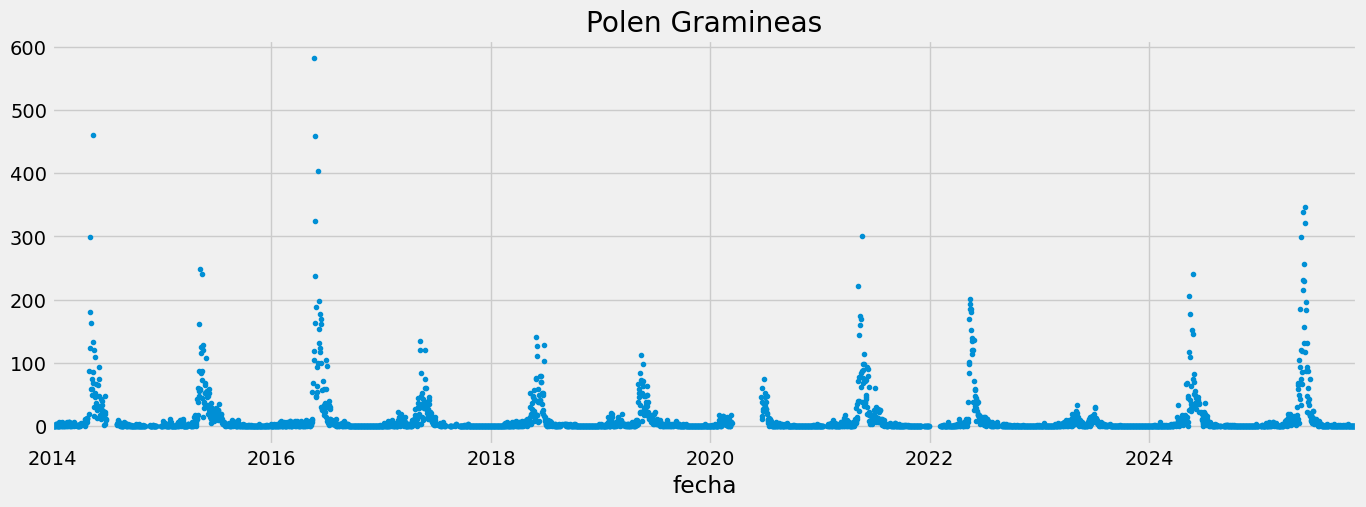

,Unnamed: 0.1,Unnamed: 0,tipo_polinico,granos_de_polen_x_metro_cubico,año,temperature_2m (°C),wind_speed_10m (km/h),wind_gusts_10m (km/h),relative_humidity_2m (%),wind_direction_10m (°),...,precip_autumn_last_year,precip_winter_last_year,temp_mean_spring_summer_last,humidity_sum_spring_summer_last,co2_mean_april_may_last,o3_mean_april_may_last,no2_mean_april_may_last,drought_days_summer_last,growing_degree_days_last,polen_last_year
fecha,,,,,,,,,,,,,,,,,,,,,
2014-01-01,0,0,Gramíneas,0.0,2014,1.066667,12.283333,22.187500,89.375000,173.541667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-02,1,1,Gramíneas,0.0,2014,3.341667,15.962500,28.450000,85.958333,171.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,2,2,Gramíneas,0.0,2014,5.587500,14.808333,27.833333,87.875000,195.541667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-04,3,3,Gramíneas,1.0,2014,6.216667,15.016667,29.950000,85.125000,171.166667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-05,4,4,Gramíneas,0.0,2014,4.987500,12.566667,23.804167,91.958333,227.375000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-19,4340,4340,Gramíneas,0.0,2025,2.995833,12.670833,27.837500,86.291667,190.916667,...,5.975,6.808333,15.858311,12733.625,0.319672,71.901639,21.557377,92.0,2699.775,9.446746
2025-11-20,4341,4341,Gramíneas,1.0,2025,1.550000,13.504167,29.700000,90.666667,233.500000,...,5.975,6.808333,15.858311,12733.625,0.319672,71.901639,21.557377,92.0,2699.775,9.446746
2025-11-21,4342,4342,Gramíneas,1.0,2025,-1.445833,8.129167,17.633333,87.500000,272.708333,...,5.975,6.808333,15.858311,12733.625,0.319672,71.901639,21.557377,92.0,2699.775,9.446746


In [212]:
df = pd.read_csv("new_datasets/gramineas_2014_2025.csv")
df = df.set_index("fecha")
df.index = pd.to_datetime(df.index)

df["granos_de_polen_x_metro_cubico"].plot(
    style=".", figsize=(15, 5), color=color_pal[0], title="Polen Gramineas"
)
plt.show()

df

### Split data (Train/Test)


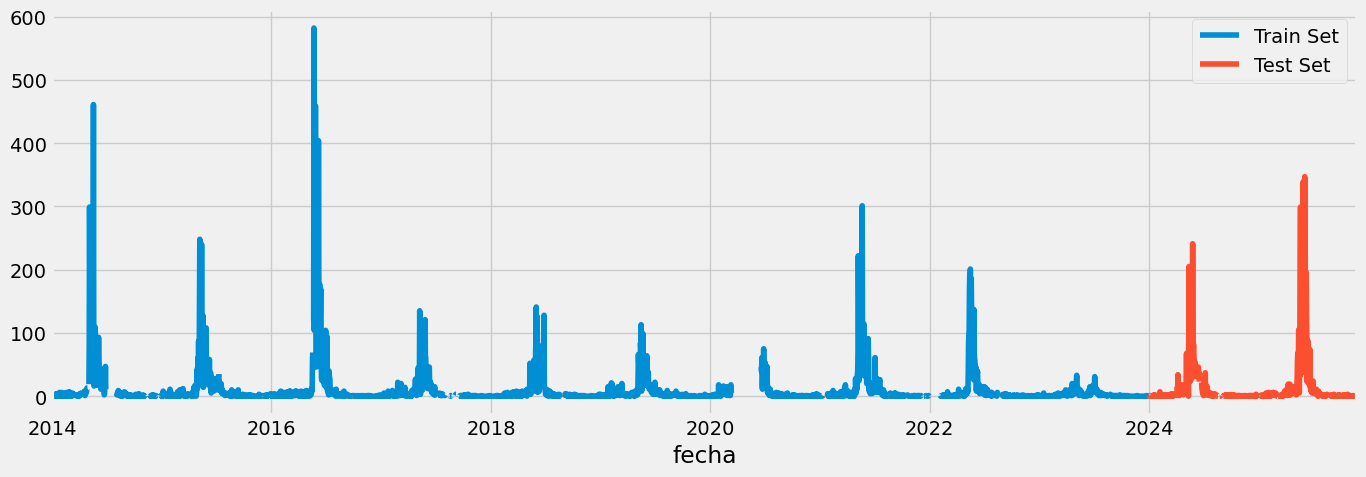

In [213]:
train = df.loc[df.index < "2024-01-01"]
test = df.loc[df.index >= "2024-01-01"]
fig, ax = plt.subplots(figsize=(15, 5))
train['granos_de_polen_x_metro_cubico'].plot(ax=ax)
test['granos_de_polen_x_metro_cubico'].plot(ax=ax)
ax.legend(["Train Set", "Test Set"])
plt.show()

### Create our model


In [ ]:
def create_features(df):
    df = df.copy()
    df['day'] = (df.index.month.astype(int)*12) +df.index.day.astype(int)
    df['month'] = df.index.month.astype(int)
    df['temperature_2m'] = df.get('temperature_2m (°C)')
    df['wind_speed_10m'] = df.get('wind_speed_10m (km/h)')
    df['wind_gusts_10m'] = df.get('wind_gusts_10m (km/h)')
    df['relative_humidity_2m'] = df.get('relative_humidity_2m (%)')
    df['wind_direction_10m'] = df.get('wind_direction_10m (°)')
    df['et0_fao_evapotranspiration'] = df.get('et0_fao_evapotranspiration (mm)')
    df['dew_point_2m'] = df.get('dew_point_2m (°C)')
    df['rain'] = df.get('rain (mm)')
    df['vapour_pressure_deficit'] = df.get('vapour_pressure_deficit (kPa)')
    df['soil_moisture_0_to_7cm'] = df.get('soil_moisture_0_to_7cm (m³/m³)')
    df['soil_temperature_0_to_7cm'] = df.get('soil_temperature_0_to_7cm (°C)')
    df['cloud_cover'] = df.get('cloud_cover (%)')
    df['shortwave_radiation'] = df.get('shortwave_radiation (W/m²)')

    df['Benceno'] = df.get('Benceno (ug/m3)')
    df['CO'] = df.get('CO (mg/m3)')
    df['NO'] = df.get('NO (ug/m3)')
    df['NO2'] = df.get('NO2 (ug/m3)')
    df['NOx'] = df.get('NOx (ug/m3)')
    df['O3'] = df.get('O3 (ug/m3)')
    df['PM10'] = df.get('PM10 (ug/m3)')
    df['PM2.5'] = df.get('PM2.5 (ug/m3)')
    df['Tolueno'] = df.get('Tolueno (ug/m3)')

    df['precip_autumn_last_year'] = df.get('precip_autumn_last_year')
    df['precip_winter_last_year'] = df.get('precip_winter_last_year')
    df['temp_mean_spring_summer_last'] = df.get('temp_mean_spring_summer_last')
    df['humidity_sum_spring_summer_last'] = df.get('humidity_sum_spring_summer_last')
    df['co2_mean_april_may_last'] = df.get('co2_mean_april_may_last')
    df['o3_mean_april_may_last'] = df.get('o3_mean_april_may_last')
    df['no2_mean_april_may_last'] = df.get('no2_mean_april_may_last')
    df['drought_days_summer_last'] = df.get('drought_days_summer_last')
    df['growing_degree_days_last'] = df.get('growing_degree_days_last')

    return df

df = create_features(df)

In [215]:
train = create_features(train)
test = create_features(test)

FEATURES = ['day',
            'month',
            'temperature_2m',
            'wind_speed_10m',
            'wind_gusts_10m',
            'relative_humidity_2m',
            'wind_direction_10m',
            'et0_fao_evapotranspiration',
            'dew_point_2m',
            'rain',
            'vapour_pressure_deficit',
            'soil_moisture_0_to_7cm',
            'soil_temperature_0_to_7cm',
            'cloud_cover',
            'shortwave_radiation',
            'Benceno',
            'CO', 
            'NO', 
            'NO2', 
            'NOx', 
            'O3', 
            'PM10', 
            'PM2.5',
            'Tolueno',
            'precip_autumn_last_year',
            'precip_winter_last_year',
            'temp_mean_spring_summer_last',
            'humidity_sum_spring_summer_last',
            'co2_mean_april_may_last',
            'o3_mean_april_may_last',
            'no2_mean_april_may_last',
            'drought_days_summer_last',
            'growing_degree_days_last'
        ]
TARGET = 'granos_de_polen_x_metro_cubico'

# Eliminar filas nulas
train = train.dropna(subset=[TARGET])

X_train = train[FEATURES]
y_train = train[TARGET]

# Eliminar filas nulas
test = test.dropna(subset=[TARGET])

X_test = test[FEATURES]
y_test = test[TARGET]

train

,Unnamed: 0.1,Unnamed: 0,tipo_polinico,granos_de_polen_x_metro_cubico,año,temperature_2m (°C),wind_speed_10m (km/h),wind_gusts_10m (km/h),relative_humidity_2m (%),wind_direction_10m (°),...,shortwave_radiation,Benceno,CO,NO,NO2,NOx,O3,PM10,PM2.5,Tolueno
fecha,,,,,,,,,,,,,,,,,,,,,
2014-01-01,0,0,Gramíneas,0.0,2014,1.066667,12.283333,22.187500,89.375000,173.541667,...,28.416667,0.5,0.2,16.0,35.0,60.0,27.0,9.0,7.0,0.8
2014-01-02,1,1,Gramíneas,0.0,2014,3.341667,15.962500,28.450000,85.958333,171.000000,...,21.750000,0.5,0.2,35.0,45.0,98.0,26.0,9.0,7.0,1.6
2014-01-03,2,2,Gramíneas,0.0,2014,5.587500,14.808333,27.833333,87.875000,195.541667,...,35.958333,0.5,0.2,36.0,49.0,104.0,26.0,12.0,8.0,2.4
2014-01-04,3,3,Gramíneas,1.0,2014,6.216667,15.016667,29.950000,85.125000,171.166667,...,31.625000,0.4,0.1,14.0,32.0,53.0,46.0,8.0,5.0,0.9
2014-01-05,4,4,Gramíneas,0.0,2014,4.987500,12.566667,23.804167,91.958333,227.375000,...,13.750000,0.5,0.2,16.0,36.0,61.0,38.0,14.0,8.0,1.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,3647,3647,Gram?neas,0.0,2023,3.687500,14.912500,26.912500,86.291667,208.666667,...,38.333333,1.3,0.7,81.0,56.0,181.0,9.0,38.0,21.0,5.6
2023-12-28,3648,3648,Gram?neas,0.0,2023,8.020833,22.579167,39.104167,71.833333,226.583333,...,36.708333,1.3,0.7,76.0,58.0,175.0,5.0,41.0,24.0,5.4
2023-12-29,3649,3649,Gram?neas,0.0,2023,8.816667,25.250000,44.925000,77.708333,233.083333,...,26.625000,1.7,0.8,83.0,61.0,187.0,4.0,46.0,27.0,5.8


In [216]:
#reg = xgb.XGBRegressor(
#    base_score=0.5,
#    booster="gbtree",
#    n_estimators=1000,
#    early_stopping_rounds=50,
#    objective="reg:linear",
#    max_depth=3,
#    learning_rate=0.01,
#)

reg = xgb.XGBRegressor(
    base_score=0.5,
    booster="gbtree",
    n_estimators=889,
    max_depth=5,
    early_stopping_rounds=50,
    objective="reg:linear",
    learning_rate=0.11075223202563271,
    subsample=0.8665262559694884,
    colsample_bytree=0.8112043296487047,
    alpha=0.041071289472733835,
    #lambda=0.04239388063719013
)
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

[0]	validation_0-rmse:29.98737	validation_1-rmse:42.44810
[100]	validation_0-rmse:5.65751	validation_1-rmse:32.31748


c:\Users\sergi\anaconda3\Lib\site-packages\xgboost\callback.py:386: UserWarning: [18:27:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:282: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[130]	validation_0-rmse:4.50904	validation_1-rmse:32.28165


XGBRegressor(alpha=0.041071289472733835, base_score=0.5, booster='gbtree',
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8112043296487047, device=None,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.11075223202563271,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=889, n_jobs=None, ...)

In [217]:
def objective(trial):
    # Definimos los hiperparámetros que queremos probar
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        # Estos dos ayudan a la selección automática de variables que querías:
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
    }

    # Entrenamos el modelo con los parámetros sugeridos
    model = xgb.XGBRegressor(**param, random_state=42)
    model.fit(X_train, y_train)
    
    # Predecimos y calculamos el R2
    preds = model.predict(X_test)
    r2 = r2_score(y_test, preds)
    
    return r2 # Optuna intentará maximizar este valor

In [218]:
# Crear el estudio (direction="maximize" porque queremos el R2 más alto)
#study = optuna.create_study(direction="maximize")
#study.optimize(objective, n_trials=50) # Prueba con 50 o 100 intentos

#print(f"Mejor R2 encontrado: {study.best_value:0.2f}")
#print("Mejores parámetros:", study.best_params)

In [219]:
# Ver qué parámetro influyó más en el R2
#optuna.visualization.plot_param_importances(study).show()

# Ver el historial de mejora
#optuna.visualization.plot_optimization_history(study).show()

### Feature importance

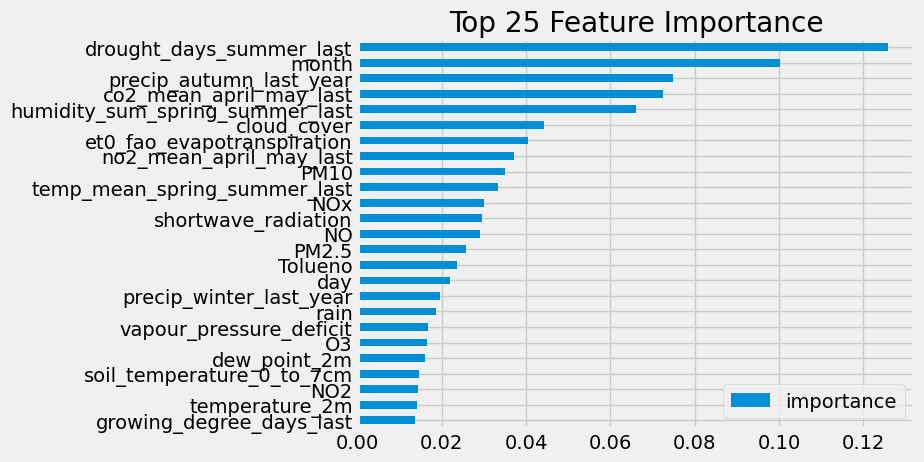

In [220]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance', ascending=False).head(25).sort_values('importance').plot(kind='barh', title='Top 25 Feature Importance')
plt.show()

### Predictions

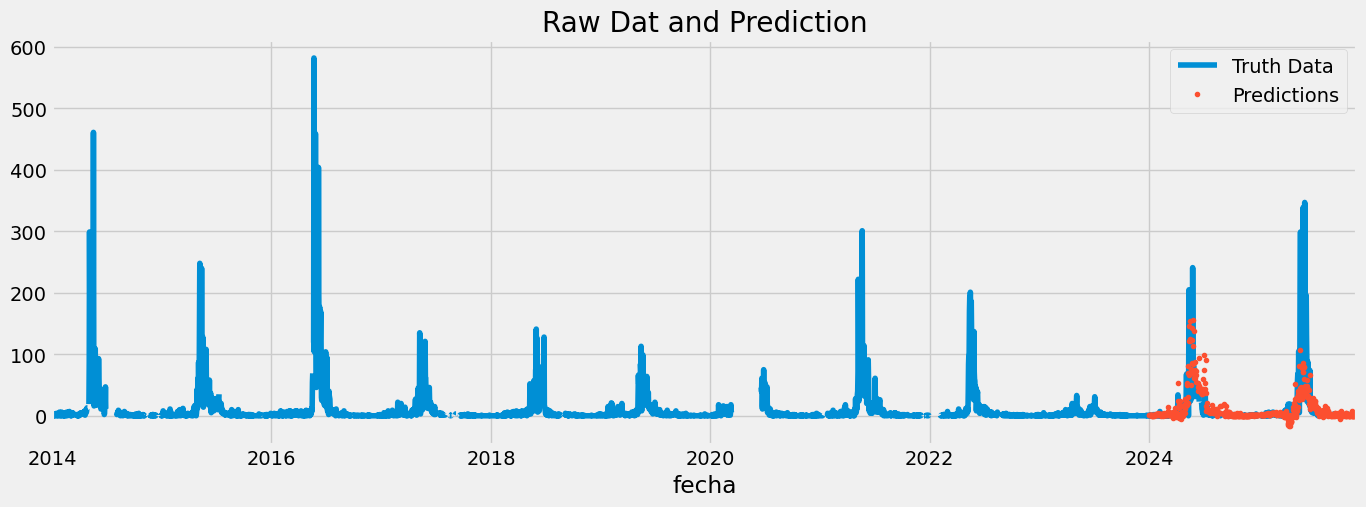

In [221]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['granos_de_polen_x_metro_cubico']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

### Score (RMSE, MAE)

In [222]:
score = np.sqrt(mean_squared_error(test['granos_de_polen_x_metro_cubico'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

mae_score = mean_absolute_error(test['granos_de_polen_x_metro_cubico'], test['prediction'])
print(f'MAE Score on Test set: {mae_score:0.2f}')

RMSE Score on Test set: 32.26
MAE Score on Test set: 11.50


### SCORE (R2)

In [223]:
from sklearn.metrics import r2_score
r2 = r2_score(test['granos_de_polen_x_metro_cubico'], test['prediction'])
print(f'R2 Score: {r2:0.2f}')

R2 Score: 0.39
